# Demo

Given a youtube song link, can the models determine its music genre

In [1]:
import os
import pandas as pd
from IPython.display import YouTubeVideo
from __future__ import unicode_literals
import youtube_dl
import shutil
import librosa
import librosa.display
import numpy as np
import keras
import joblib
from tensorflow.keras.layers import Flatten
from tensorflow.keras.models import Model
import tensorflow as tf

## Models

In [2]:
MODELS_PATH = os.path.join(os.getcwd(), 'models', 'models.csv')
MODELS = pd.read_csv(MODELS_PATH).set_index("Model Name")
MODELS = MODELS.sort_values('Test Accuracy', ascending = False)
MODELS = MODELS[MODELS['Split'].isin([5, 8, 10])]
MODELS

,Method,Dataset,Feature,Split,Test Accuracy,Test Loss,Train Accuracy,Train Loss,Best Epoch,Validation Accuracy,Validation Loss,Training Accuracy,Training Loss
Model Name,,,,,,,,,,,,,
7628_CNN_STFT_MELSPECTROGRAM_KNN_GTZAN_8,CNN + KNN,GTZAN,"STFT, MELSPECTROGRAM",8,0.958125,NaN,0.990000,NaN,NaN,0.975313,NaN,NaN,NaN
6428_CNN_STFT_MFCC_KNN_GTZAN_8,CNN + KNN,GTZAN,"STFT, MFCC",8,0.953125,NaN,0.990938,NaN,NaN,0.972344,NaN,NaN,NaN
379_CNN_STFT_MELSPECTROGRAM_SVM_GTZAN_8,CNN + SVM,GTZAN,"STFT, MELSPECTROGRAM",8,0.950625,NaN,0.999375,NaN,NaN,0.981250,NaN,NaN,NaN
4367_CNN_STFT_MFCC_SVM_GTZAN_8,CNN + SVM,GTZAN,"STFT, MFCC",8,0.940000,NaN,0.999375,NaN,NaN,0.977656,NaN,NaN,NaN
6475_CNN_STFT_MELSPECTROGRAM_LR_GTZAN_8,CNN + LR,GTZAN,"STFT, MELSPECTROGRAM",8,0.932500,NaN,0.999375,NaN,NaN,0.971562,NaN,NaN,NaN
757_CNN_STFT_MFCC_SVM_EXTENDEDBALLROOM_8,CNN + SVM,ExtendedBallroom,"STFT, MFCC",8,0.924076,NaN,0.980194,NaN,NaN,0.960737,NaN,NaN,NaN
4630_CNN_STFT_MFCC_LR_GTZAN_8,CNN + LR,GTZAN,"STFT, MFCC",8,0.921250,NaN,0.999062,NaN,NaN,0.968750,NaN,NaN,NaN
1584_CNN_STFT_MFCC_RF_EXTENDEDBALLROOM_8,CNN + RF,ExtendedBallroom,"STFT, MFCC",8,0.919693,NaN,0.999843,NaN,NaN,0.954083,NaN,NaN,NaN
5399_CNN_STFT_MELSPECTROGRAM_SVM_EXTENDEDBALLROOM_8,CNN + SVM,ExtendedBallroom,"STFT, MELSPECTROGRAM",8,0.919537,NaN,0.988414,NaN,NaN,0.960815,NaN,NaN,NaN


## Testing

In [3]:
def process(name, time_split, file_type, verbose = False, save = False):
    N_FFT = 2048
    HOP_LENGTH = 1024
    N_MELS = 64
    N_MFCC = 13

    aud_path = os.path.join(os.getcwd(), "demo_songs", name)
    if not os.path.exists(aud_path):
        print("Video Demo not found:", aud_path)
        return
        
    features = ("stft", "melspectrogram", "mfcc")
    
    audio_path = os.path.join(aud_path, name + file_type)
    y, sr = librosa.load(audio_path) # can user offset and duration for 5 second intervals
    
    for feature in features:
        processed = []
        
        if feature == "stft":
            feat = np.abs(librosa.stft(y, hop_length = HOP_LENGTH, n_fft = N_FFT))
        elif feature == "mfcc":
            feat = librosa.feature.mfcc(y = y, sr = sr, hop_length = HOP_LENGTH, 
                                                  n_fft = N_FFT)
        elif feature == "melspectrogram":
            feat = librosa.feature.melspectrogram(y = y, sr = sr, n_mels = N_MELS, n_fft = N_FFT,
                                                 hop_length = HOP_LENGTH)
        feat = librosa.power_to_db(feat ** 2) # feat ** 2 for amplitude to db
        
        # find max length that is //10, 8, 5, 4, 2
        max_len = 2
        for i in range(feat.shape[1], 2, -1):
            if i % 640 == 0:
                max_len = i
                break
                
        out = feat[:, :max_len] # should be //10, 8, 5, 4, 2 while almost being close to max length
        
        t_split = np.hsplit(out, max_len // 640) # split so 640 length each
        for t in t_split:
            out_split = np.hsplit(t, time_split)
            for split in out_split:
                processed.append(split)
                #librosa.display.specshow(split[:, :], sr=sr, hop_length = HOP_LENGTH, x_axis = 'time', y_axis = 'mel')
            #librosa.display.specshow(out[:, :], sr=sr, hop_length = HOP_LENGTH)
            
        X = np.array(processed)
        np.save(os.path.join(aud_path, f"{feature + str(time_split)}.npy"), X)

In [4]:
def get_feat(video, feat, split):
    feat = feat.lower()
    X = np.load(os.path.join(os.getcwd(), "demo_songs", video, f"{feat}{split}.npy"))
    
    return X

In [5]:
def get_model(mod, data, feature, split):
    models_path = os.path.join(os.getcwd(), 'models')
    for file in os.listdir(models_path):
        if file.endswith('_'.join([mod, feature.upper(), data.upper(), str(split)]) + '.h5'):
            model = keras.models.load_model(os.path.join(models_path, file))
            break
    return model

In [6]:
class MyLogger(object):
    def debug(self, msg):
        pass

    def warning(self, msg):
        pass

    def error(self, msg):
        print(msg)


def my_hook(d):
    if d['status'] == 'finished':
        print('Done downloading, now converting ...')

ydl_opts = {
    'format': 'bestaudio/best',
    'postprocessors': [{
        'key': 'FFmpegExtractAudio',
        'preferredcodec': 'mp3',
        'preferredquality': '192',
    }],
    'logger': MyLogger(),
    'progress_hooks': [my_hook],
}

In [7]:
GTZAN_GENRES = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
EXTENDED_BALLROOM_GENRES = ['chacha', 'foxtrot', 'jive', 'quickstep', 'rumba', 'samba', 'tango', 'viennesewaltz', 'waltz']

### Download

In [ ]:
yt_link = "https://www.youtube.com/watch?v=qGNHoPbqJYk"
name = 'TJ'

# download
with youtube_dl.YoutubeDL(ydl_opts) as ydl:
    ydl.download([yt_link])

for file in os.listdir(os.getcwd()):
    if file.endswith('.mp3'):
        file_type = '.mp3'
        os.path.isdir(f'demo_songs/{name}') or os.mkdir(f'demo_songs/{name}')
        shutil.move(file, f'demo_songs/{name}/{name}.mp3')
    if file.endswith('.wav'):
        file_type = '.wav'
        os.path.isdir(f'demo_songs/{name}') or os.mkdir(f'demo_songs/{name}')
        shutil.move(file, f'demo_songs/{name}/{name}.wav')
        
# spectograms + splitting
process(name, 8, file_type) # 8 split

## GTZAN

YMCA = vR12DLbxcb4

Daft Punk - Get Lucky = 5NV6Rdv1a3I

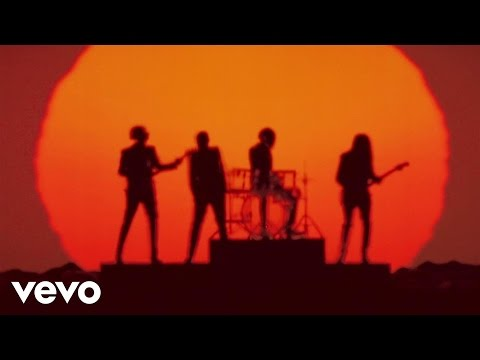

In [8]:
YouTubeVideo('5NV6Rdv1a3I', width = 800, height = 500)

## Prediction

In [9]:
# video name
name = 'DP Get Lucky'

# load model
data = 'GTZAN'
b_mod = 'CNN'
split = 8
feat1 = 'STFT'
feat2 = 'MELSPECTROGRAM'
model1 = get_model(b_mod, data, feat1, split)
model2 = get_model(b_mod, data, feat2, split)

model_name = '7628_CNN_STFT_MELSPECTROGRAM_KNN_GTZAN_8'
model = joblib.load(f'models/{model_name}.pkl')

# use spectrograms to determine genre
m1_layer = [l.output for l in model1.layers if type(l) == Flatten][0]
m2_layer = [l.output for l in model2.layers if type(l) == Flatten][0]
m1 = Model(inputs = model1.input, outputs = m1_layer)
m2 = Model(inputs = model2.input, outputs = m2_layer)

# feature extraction
feat1_x = get_feat(name, feat1, split)
feat2_x = get_feat(name, feat2, split)

m1_output = m1.predict(feat1_x)
m2_output = m2.predict(feat2_x)
output_features = np.column_stack((m1_output, m2_output)) # concatenation

PREDICTIONS = model.predict(output_features)

# majority voting
GENRES = {}
gens = []
for pred in PREDICTIONS:
    if GTZAN_GENRES[pred] in GENRES:
        GENRES[GTZAN_GENRES[pred]] += 1
    else:
        GENRES[GTZAN_GENRES[pred]] = 1
    gens.append(GTZAN_GENRES[pred])
print(gens, "\n")

print("Summary:")
print(GENRES, "\n")

predicted_genre = max(GENRES, key = GENRES.get)
print("Predicted:", predicted_genre)

['rock', 'disco', 'disco', 'disco', 'rock', 'disco', 'disco', 'rock', 'disco', 'hiphop', 'pop', 'rock', 'pop', 'pop', 'pop', 'pop', 'disco', 'pop', 'pop', 'disco', 'disco', 'rock', 'rock', 'disco', 'hiphop', 'rock', 'country', 'pop', 'pop', 'pop', 'disco', 'rock', 'pop', 'disco', 'reggae', 'hiphop', 'rock', 'hiphop', 'disco', 'disco', 'hiphop', 'disco', 'hiphop', 'disco', 'disco', 'disco', 'disco', 'disco', 'pop', 'disco', 'rock', 'hiphop', 'pop', 'hiphop', 'disco', 'disco', 'disco', 'hiphop', 'hiphop', 'hiphop', 'country', 'disco', 'disco', 'rock'] 

Summary:
{'rock': 11, 'disco': 26, 'hiphop': 11, 'pop': 13, 'country': 2, 'reggae': 1} 

Predicted: disco


## Extended Ballroom

La canzone di Marinella = zbNkLDOhxpc

Tom and Jerry = xpAjbaNBPqA

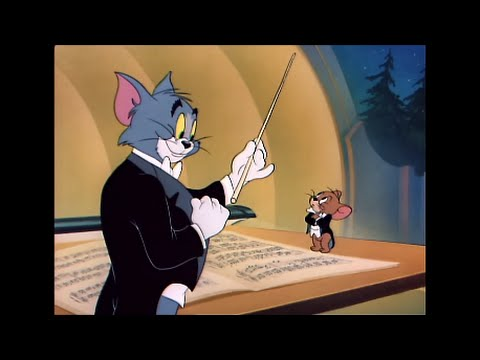

In [10]:
YouTubeVideo('xpAjbaNBPqA', width = 800, height = 500)

### Prediction

In [11]:
# video name
name = 'Tom and Jerry'

# load model
data = 'EXTENDEDBALLROOM'
b_mod = 'CNN'
split = 8
feat1 = 'STFT'
feat2 = 'MFCC'
model1 = get_model(b_mod, data, feat1, split)
model2 = get_model(b_mod, data, feat2, split)

model_name = '757_CNN_STFT_MFCC_SVM_EXTENDEDBALLROOM_8'
model = joblib.load(f'models/{model_name}.pkl')

# use spectrograms to determine genre
m1_layer = [l.output for l in model1.layers if type(l) == Flatten][0]
m2_layer = [l.output for l in model2.layers if type(l) == Flatten][0]
m1 = Model(inputs = model1.input, outputs = m1_layer)
m2 = Model(inputs = model2.input, outputs = m2_layer)

# feature extraction
feat1_x = get_feat(name, feat1, split)
feat2_x = get_feat(name, feat2, split)

m1_output = m1.predict(feat1_x)
m2_output = m2.predict(feat2_x)
output_features = np.column_stack((m1_output, m2_output)) # concatenation

PREDICTIONS = model.predict(output_features)

# majority voting
GENRES = {}
gens = []
for pred in PREDICTIONS:
    if EXTENDED_BALLROOM_GENRES[pred] in GENRES:
        GENRES[EXTENDED_BALLROOM_GENRES[pred]] += 1
    else:
        GENRES[EXTENDED_BALLROOM_GENRES[pred]] = 1
    gens.append(EXTENDED_BALLROOM_GENRES[pred])
print(gens, "\n")

print("Summary:")
print(GENRES, "\n")

predicted_genre = max(GENRES, key = GENRES.get)
print("Predicted:", predicted_genre)

['rumba', 'waltz', 'waltz', 'waltz', 'waltz', 'waltz', 'waltz', 'rumba', 'rumba', 'viennesewaltz', 'quickstep', 'tango', 'tango', 'tango', 'tango', 'tango', 'tango', 'tango', 'waltz', 'tango', 'waltz', 'samba', 'foxtrot', 'quickstep', 'tango', 'tango', 'waltz', 'quickstep', 'tango', 'tango', 'tango', 'tango', 'tango', 'jive', 'foxtrot', 'tango', 'tango', 'viennesewaltz', 'jive', 'tango', 'viennesewaltz', 'tango', 'tango', 'viennesewaltz', 'tango', 'tango', 'tango', 'tango'] 

Summary:
{'rumba': 3, 'waltz': 9, 'viennesewaltz': 4, 'quickstep': 3, 'tango': 24, 'samba': 1, 'foxtrot': 2, 'jive': 2} 

Predicted: tango
